In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib
import urllib.request
from datetime import datetime, timedelta, date
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import altair as alt
import streamlit as st
import statsmodels.api as sm

In [4]:
variable = 'new_cases_'
initialdate = '2020-01-01'   # first day of the year, where most of our data starts
# moving intialdate by 6, since we later apply 7-day rolling mean to our data:
initialdateshift = str(date.fromordinal(datetime.strptime(initialdate, '%Y-%m-%d').toordinal() + 6)) 
enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

country = 'Denmark'
col = variable + country
url1 = 'https://raw.githubusercontent.com/martaarozarena/KSchool-Master-Final-Project/master/data/endogenous.csv'
covid_ctry_varR = pd.read_csv(url1, parse_dates=['date'], index_col=['date'], usecols=['date', col])

In [5]:
url2 = 'https://raw.githubusercontent.com/martaarozarena/KSchool-Master-Final-Project/master/data/exogenous.csv'
exog = pd.read_csv(url2, parse_dates=['date'], index_col=['date'])
exog = exog.loc[:, exog.columns.str.contains(country)]

In [6]:
exog.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14',
               '2020-09-15', '2020-09-16'],
              dtype='datetime64[ns]', name='date', length=260, freq=None)

In [7]:
exog.iloc[-1, exog.columns.str.contains('Testing|Contact')]

H2_Testing policy_Denmark     3.0
H3_Contact tracing_Denmark    2.0
Name: 2020-09-16 00:00:00, dtype: float64

In [8]:
last_test_value = exog.iloc[-1, exog.columns.str.contains('Testing|Contact')][0]
int(last_test_value)

3

In [9]:
last_contact_value = exog.iloc[-1, exog.columns.str.contains('Testing|Contact')][1]
last_contact_value

2.0

In [10]:
exog.columns

Index(['positive_rate_Denmark', 'C1_School closing_Denmark',
       'C2_Workplace closing_Denmark', 'C3_Cancel public events_Denmark',
       'C4_Restrictions on gatherings_Denmark',
       'C5_Close public transport_Denmark',
       'C6_Stay at home requirements_Denmark',
       'C7_Restrictions on internal movement_Denmark',
       'C8_International travel controls_Denmark',
       'H1_Public information campaigns_Denmark', 'H2_Testing policy_Denmark',
       'H3_Contact tracing_Denmark', 'mask_Denmark', 'flightsArr_Denmark'],
      dtype='object')

In [11]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdate, new_date, freq='D')
exog_futur = exog.reindex(new_index).interpolate()

In [12]:
exog_futur.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', length=274, freq='D')

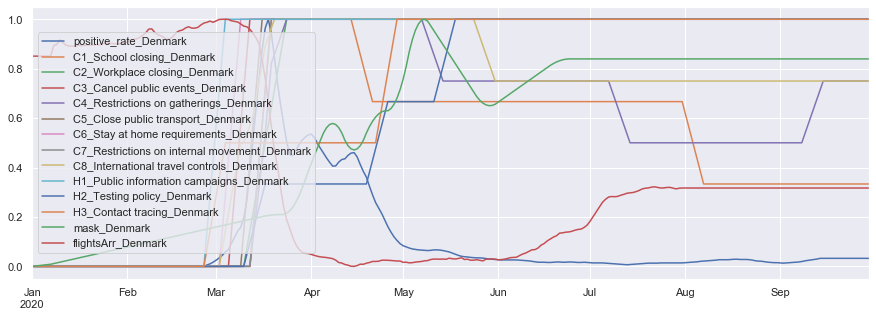

In [13]:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_futur)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_futur.index, columns=exog_futur.columns)
X_fc = scaled_input_fc
X_fc.plot()

In [14]:
url3 = 'https://github.com/martaarozarena/KSchool-Master-Final-Project/raw/master/models/' + country +'SARIMAXmodel.pkl'
model = joblib.load(urllib.request.urlopen(url3))

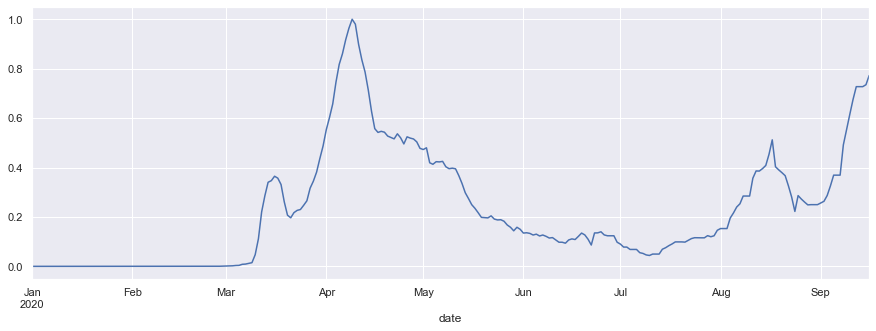

In [15]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR)
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.columns[0])
scaled_output.plot()

In [16]:
scaled_output.name

'new_cases_Denmark'

In [17]:
past_rs = covid_ctry_varR.reset_index()

In [18]:
results = model.get_forecast(steps=14, exog=X_fc[new_begin:new_date])
mean_forecast = results.predicted_mean

forecast14 = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
forecast14S = pd.Series(forecast14.flatten(), index=mean_forecast.index, name='new_cases_forecast')
future_rs = forecast14S.to_frame().reset_index()

In [19]:
# Get confidence intervals of  predictions
confidence_intervals = results.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ' + scaled_output.name]
upper_limits = confidence_intervals.loc[:,'upper ' + scaled_output.name]

forecast14_ll = sc_out.inverse_transform(lower_limits.values.reshape(-1,1))
forecast14_llS = pd.Series(forecast14_ll.flatten(), index=lower_limits.index, name='new_cases_forecast_ll')
fcast_ll_df = forecast14_llS.to_frame().reset_index()

forecast14_ul = sc_out.inverse_transform(upper_limits.values.reshape(-1,1))
forecast14_ulS = pd.Series(forecast14_ul.flatten(), index=upper_limits.index, name='new_cases_forecast_ul')
fcast_ul_df = forecast14_ulS.to_frame().reset_index()

In [40]:
confidence_intervals

,lower new_cases_Denmark,upper new_cases_Denmark
2020-09-16,0.699043,0.782187
2020-09-17,0.667115,0.818347
2020-09-18,0.637765,0.849894
2020-09-19,0.611427,0.877374
2020-09-20,0.587825,0.901568
2020-09-21,0.566527,0.923174
2020-09-22,0.547120,0.942741
2020-09-23,0.529261,0.960683
2020-09-24,0.512676,0.977312
2020-09-25,0.497151,0.992859


In [20]:
conf_int = pd.concat([fcast_ll_df, fcast_ul_df.iloc[:, 1]], axis=1)
conf_int

,index,new_cases_forecast_ll,new_cases_forecast_ul
0,2020-09-16,229.186325,256.445566
1,2020-09-17,218.718295,268.300879
2,2020-09-18,209.095718,278.643975
3,2020-09-19,200.460559,287.653352
4,2020-09-20,192.722717,295.585554
5,2020-09-21,185.739994,302.669222
6,2020-09-22,179.377309,309.084335
7,2020-09-23,173.521989,314.966885
8,2020-09-24,168.084405,320.418612
9,2020-09-25,162.994416,325.515946


In [21]:
covid_ctry_varR.columns[0]

'new_cases_Denmark'

In [22]:
ttt = forecast14S.head(1).to_frame()
ttt.columns = [covid_ctry_varR.tail(1).columns[0]]
ttt

,new_cases_Denmark
2020-09-16,242.815945


In [23]:
forecast14S.head(1).to_frame().rename(columns={forecast14S.head(1).to_frame().columns[0]:covid_ctry_varR.tail(1).columns[0]})

,new_cases_Denmark
2020-09-16,242.815945


In [24]:
new = pd.concat([covid_ctry_varR.tail(1), forecast14S.head(1).to_frame().rename(columns={forecast14S.head(1).to_frame().columns[0]:covid_ctry_varR.tail(1).columns[0]})])
new_rs = new.reset_index()
new_rs

,index,new_cases_Denmark
0,2020-09-16,253.285714
1,2020-09-16,242.815945


In [25]:
past_plt = alt.Chart(past_rs).mark_line().encode(
    x='date:T',
    y=col,
    tooltip=alt.Tooltip(col, format='.1f')
).properties(
    width=800,
    height=300
).interactive()

In [26]:
test = alt.Chart(new_rs).mark_line(opacity=0.5, size=1.2).encode(
    x='index:T',
    y=col
)

In [27]:
future_plt = alt.Chart(future_rs).mark_line(color='orange').encode(
    x=alt.X('index:T', axis=alt.Axis(title='Date')),
    y=alt.Y('new_cases_forecast', axis=alt.Axis(title='New coronavirus cases')),
    tooltip=alt.Tooltip('new_cases_forecast', format='.1f')
).properties(
    width=800,
    height=300
).interactive()

In [28]:
confint_plot = alt.Chart(conf_int).mark_area(opacity=0.2, color='orange').encode(
    alt.X('index:T'),
    alt.Y('new_cases_forecast_ll'),
    alt.Y2('new_cases_forecast_ul')
)

In [29]:
past_plt + future_plt + test + confint_plot

alt.LayerChart(...)

In [30]:
confint_plot = alt.Chart(conf_int).mark_area(opacity=0.2, color='orange').encode(
    alt.X('index:T'),
    alt.Y('new_cases_forecast_ll'),
    alt.Y2('new_cases_forecast_ul')
)
confint_plot

alt.Chart(...)

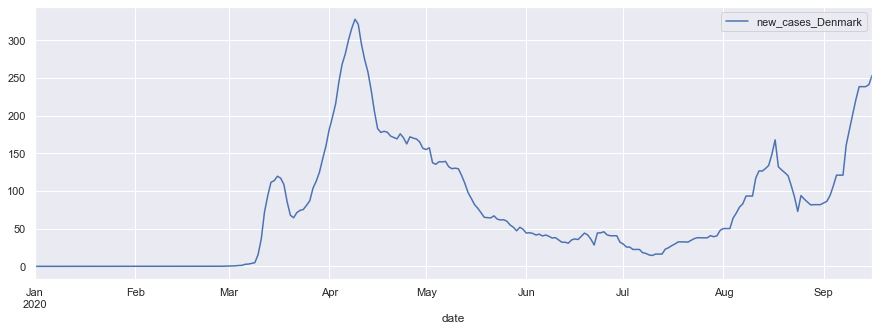

In [31]:
covid_ctry_varR.plot()

In [32]:
future_rs.columns[1]

'new_cases_forecast'

In [33]:
forecast14S_l = ["%.1f" % elem for elem in forecast14S]
print('Next 14 days forecast values: ', forecast14S_l)

Next 14 days forecast values:  ['242.8', '243.5', '243.9', '244.1', '244.2', '244.2', '244.2', '244.2', '244.3', '244.3', '244.3', '244.3', '244.3', '244.3']


In [34]:
future_rs

,index,new_cases_forecast
0,2020-09-16,242.815945
1,2020-09-17,243.509587
2,2020-09-18,243.869846
3,2020-09-19,244.056956
4,2020-09-20,244.154135
5,2020-09-21,244.204608
6,2020-09-22,244.230822
7,2020-09-23,244.244437
8,2020-09-24,244.251509
9,2020-09-25,244.255181


In [35]:
def get_model():
    url3 = 'https://github.com/martaarozarena/KSchool-Master-Final-Project/raw/master/models/' + country +'SARIMAXmodel.pkl'
    smodel = joblib.load(urllib.request.urlopen(url3))
#    smodel = sm.load_pickle('./models_old/SpainSARIMAXmodel_savedWithStatstools.pkl')
    return smodel

model =  get_model()

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      new_cases_Denmark   No. Observations:                  259
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 627.757
Date:                Thu, 17 Sep 2020   AIC                          -1223.514
Time:                        17:22:35   BIC                          -1166.666
Sample:                    01-01-2020   HQIC                         -1200.655
                         - 09-15-2020                                         
Covariance Type:                  opg                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
positive_rate_Denmark                            0.4056      0.205      1.979      0.048       0.004       0.807
C1_School closing_Denmark                        0.1706      0.192      0.890      0.374      -0.205       0.546
C2_Workplace closing_Denmark                     0.3144      0.362      0.869      0.385      -0.395       1.024
C3_Cancel public events_Denmark                  0.0004      0.374      0.001      0.999      -0.733       0.733
C4_Restrictions on gatherings_Denmark            0.0410      0.347      0.118      0.906      -0.639       0.721
C5_Close public transport_Denmark                0.1436      0.444      0.323      0.746      -0.727       1.014
C6_Stay at home requirements_Denmark             0.1183      0.851      0.139      0.889      -1.549       1.785
C7_Restrictions on internal movement_Denmark    -0.4899      0.412     -1.188      0.235      -1.298       0.318
C8_International travel controls_Denmark        -0.3039      0.480     -0.634      0.526      -1.244       0.636
H1_Public information campaigns_Denmark         -0.0870      1.592     -0.055      0.956      -3.207       3.033
H2_Testing policy_Denmark                       -0.0022      0.277     -0.008      0.994      -0.545       0.541
H3_Contact tracing_Denmark                       0.1479      0.193      0.765      0.444      -0.231       0.527
mask_Denmark                                     0.6136      0.141      4.347      0.000       0.337       0.890
flightsArr_Denmark                               0.0039      0.288      0.013      0.989      -0.561       0.569
ar.L1                                            0.5194      0.039     13.454      0.000       0.444       0.595
sigma2                                           0.0004   1.69e-05     26.623      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       82.63   Jarque-Bera (JB):              1818.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.57   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
ls = ['col_c', 'col_d']

In [38]:
ls

['col_c', 'col_d']

In [45]:
'new_cases_'.replace('new_', ' ').replace('_', ' ')

' cases '

In [46]:
var_c, varc = 'new_cases_', 'cases'

In [48]:
varc

'cases'